In [1]:
import numpy as np
import pandas as pd
import torch, os, random
from glob import glob
from torch.utils.data import DataLoader, Dataset, random_split
from matplotlib import pyplot as plt
from torchvision import transforms as T
from PIL import Image


In [2]:
class CustomDataset(Dataset):
      
    def __init__(self,root, im_type = ['.png', '.jpg', '.jpeg'], tranformations = None):
        super(). __init__()
        self.im_path = glob(f"{root}/*/*[{ i for i in im_type}]")
        self.tranformations = tranformations
        self.class_dict = {}
        count = 0
        # Create a dictionary (`class_dict`) to map class names to unique indices using the `get_class` function.
        # Iterate over image paths (`paths`) and assign unique indices to each unique class name.
        # If a class name is not already in the dictionary, add it with the current index (`count`) and increment the index counter.
        for idx, paths in enumerate(self.im_path):
            ims = self.get_class(paths)
            if ims not in self.class_dict:
                self.class_dict[ims] = count;
                count+=1

    def get_class(self, path):
        return os.path.dirname(path).split('\\')[-1]
    
    def __len__(self): return len(self.im_path)

    def __getitem__(self, idx):
        image = self.im_path[idx]
        im = Image.open(image).convert("RGB")
        gt = self.class_dict[self.get_class(image)]
        if self.tranformations is not None: im = self.tranformations(im)
        return im, gt
        
mean = [0.5652, 0.5388, 0.3994]
std = [0.2192, 0.2226, 0.2399]
tranformer = T.Compose([
                    T.Resize((224, 224)),
                    T.ToTensor(),
                    T.Normalize(mean=mean, std = std)]) 
root = "Fruits Dataset"
data = CustomDataset(root =root, tranformations = tranformer)
classes = data.class_dict
classes


{'fresh_peaches_done': 0,
 'fresh_pomegranates_done': 1,
 'fresh_strawberries_done': 2,
 'rotten_peaches_done': 3,
 'rotten_pomegranates_done': 4,
 'rotten_strawberries_done': 5}

In [5]:
data_len = len(data)
split_data = [0.8, 0.1, 0.1]
tr_len = int(data_len*split_data[0])
val_len = int(data_len*split_data[1])
ts_len = (data_len- (tr_len+val_len))

tr_ds, val_ds, ts_ds = random_split(dataset=data, lengths=[tr_len, val_len, ts_len] )
print(tr_len)
print(val_len)
print(ts_len)



1324
165
166


In [6]:
# dataloader
bs = 32
tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = 0)
val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = 0)
ts_dl = DataLoader(dataset = ts_ds, batch_size = bs, shuffle = False, num_workers = 0)

print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))


42
6
6


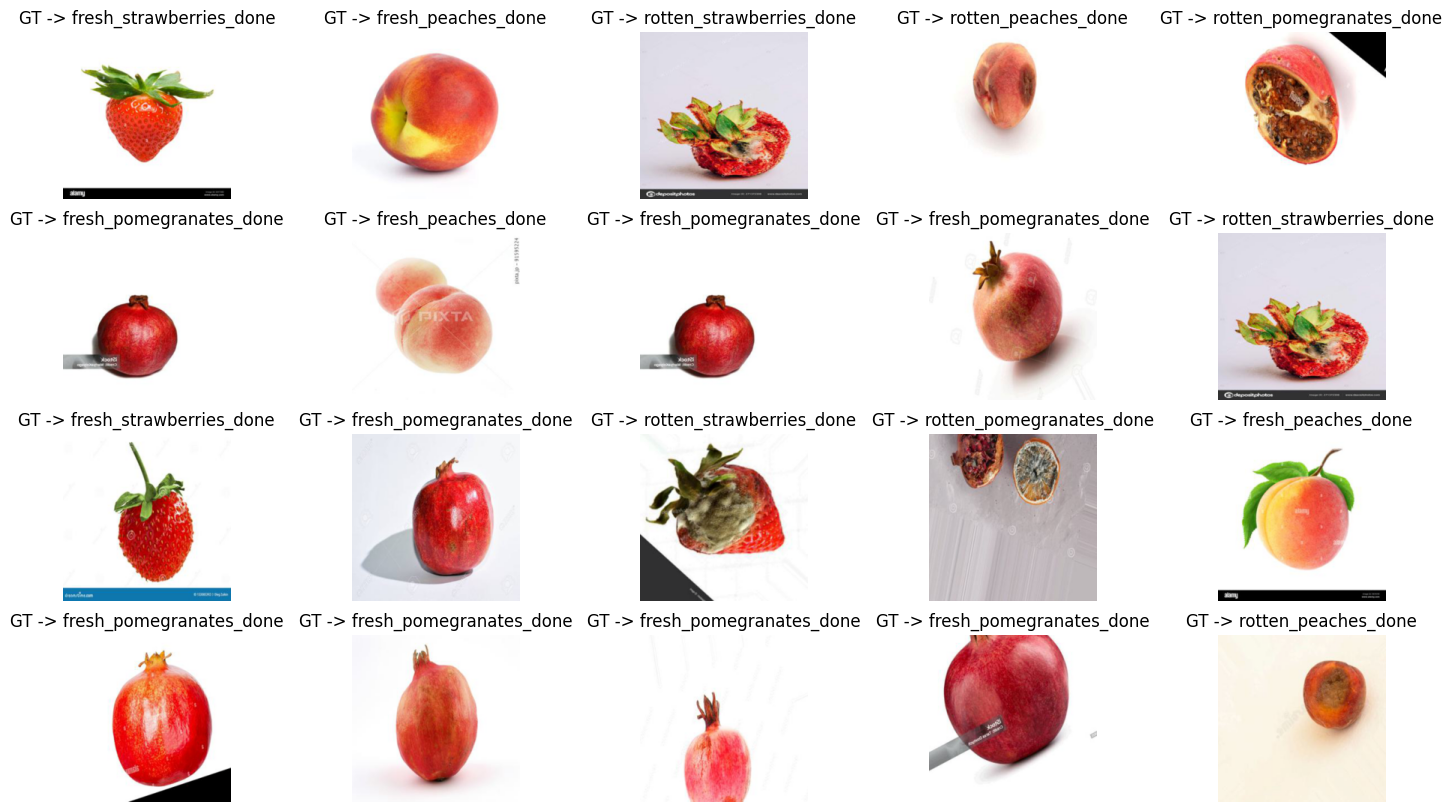

In [10]:

def tn_2_im(t, t_type = "rgb"):
    gray = T.Compose([T.Normalize(mean=[0.], std=[1/5]), T.Normalize(mean = [-0.5], std=[1])])
    rgb =  T.Compose([T.Normalize(mean=[0.,0.,0.], std=[1/std[0], 1/std[1], 1/std[2]]),
                      T.Normalize(mean = [-0.5652, -0.5388, -0.3994], std=[1.,1.,1.])])
    inv_trs = gray if t_type =="gray" else rgb
    return (inv_trs(t)*255).detach().squeeze().cpu().permute(1, 2, 0).numpy().astype("uint8") if inv_trs =="gray" else (inv_trs(t)*255).detach().cpu().permute(1, 2, 0).numpy().astype("uint8") 

def visualize(data, num_im, rows, cmap =None, class_name = None):
    assert cmap in ['rgb', 'gray']
    if cmap == "rgb": cmap = "RdBu"

    plt.figure(figsize=(18, 10))
    index = [random.randint(0, len(data)-1) for _ in range(num_im)]
    for idx, indexs in enumerate(index):
        im, gt = data[indexs]
        plt.subplot(rows, num_im//rows, idx+1)
        plt.imshow(tn_2_im(im, cmap), cmap=cmap)
        plt.imshow(tn_2_im(im))
        plt.axis('off')
        plt.title(f"GT -> {class_name[gt]}")
    
visualize(data = val_dl.dataset, num_im = 20, rows = 4, cmap ='rgb', class_name  = list(classes.keys()))
    

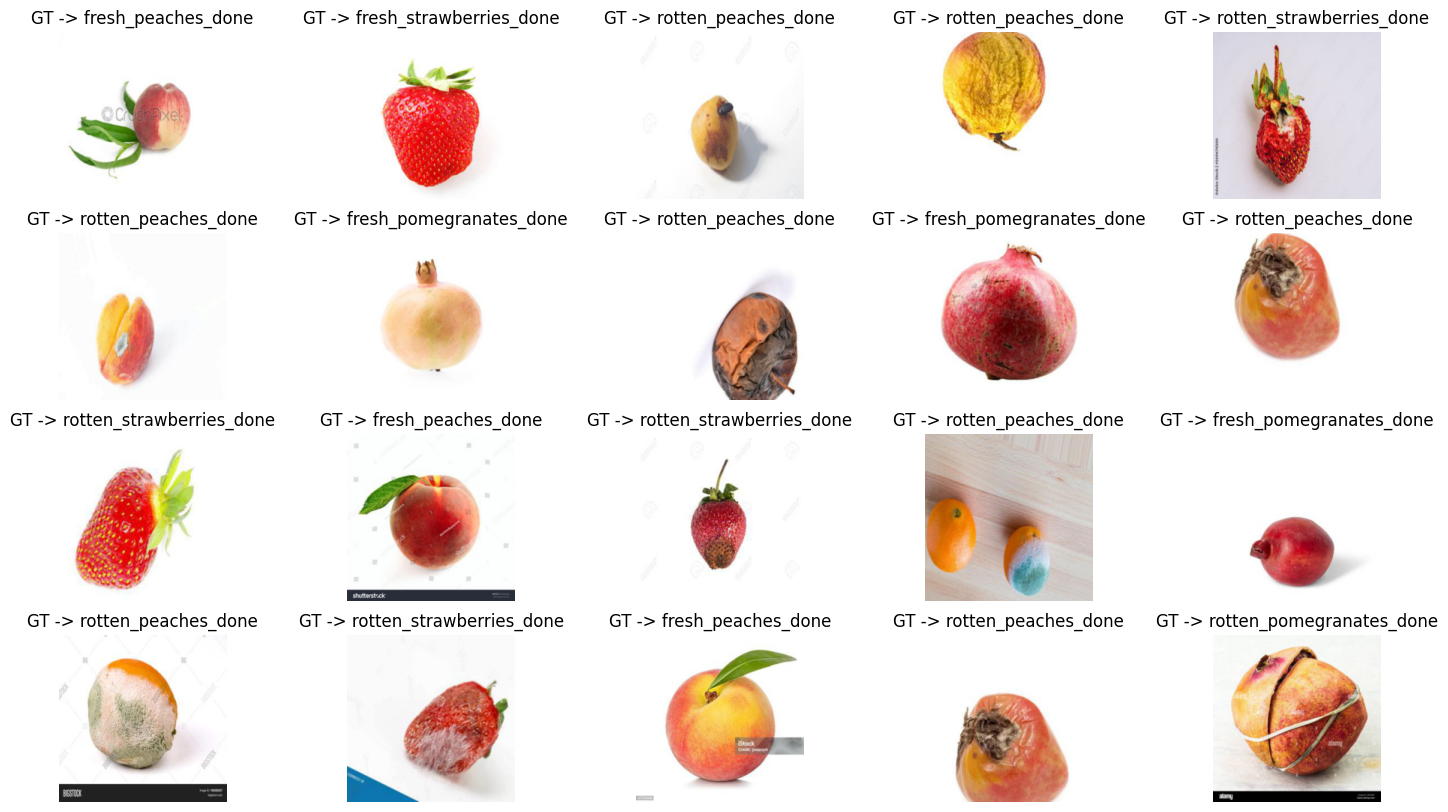

In [11]:
visualize(data = tr_dl.dataset, num_im = 20, rows = 4, cmap ='rgb', class_name  = list(classes.keys()))

In [12]:
import timm
model = timm.create_model(model_name='rexnet_200', pretrained=True, num_classes = len(classes))
loss_fn = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.SGD(params=model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else "cpu"
model.to(device)

RexNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (features): Sequential(
    (0): LinearBottleneck(
      (conv_dw): ConvNormAct(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (act_dw): ReLU6()
      (conv_pwl): ConvNormAct(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
    )
    (1): LinearBottlene

In [13]:
from tqdm import tqdm
def train( model, train_data, val_data, loss_fn, opt, epochs, save_prefix, threshold):
    tr_acc_sc, tr_epochs_loss, val_acc_sc, val_epochs_loss = [],[],[],[]
    best_epochs_loss = np.inf
    print("Train progress is starting .......")
    
    for epoc in range(epochs):
        print(f"{epoc+1} - epoc train starting")
        tr_acc, tr_loss, tr_total =0,0,0
        
        for indx, batch in enumerate(tqdm(train_data)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device) 
            pred = model(im)
            loss = loss_fn(pred, gt)
            tr_loss+=loss.item()
            pred_class = torch.argmax(pred, dim=1)
            tr_acc+=(pred_class==gt).sum().item()
            tr_total+=im.shape[0]

            # perform optimization accurancy
            opt.zero_grad()
            loss.backward()
            opt.step()
        tr_acc /=tr_total
        tr_loss /= len(train_data)
        
        tr_acc_sc.append(tr_acc)
        tr_epochs_loss.append(tr_loss)
        
        model.eval()
        with torch.no_grad():
            val_acc, val_loss, val_total = 0,0,0
            for idx, batch in enumerate(tqdm(val_data)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)
                pred = model(im)
                loss = loss_fn(pred, gt)
                val_loss+=loss.item()
                pred_class = torch.argmax(pred, dim =1)
                val_acc+=(pred_class == gt).sum().item()
                val_total+=im.shape[0]
                
            val_acc/= val_total
            val_loss/= len(val_data)
            
            val_acc_sc.append(val_acc)
            val_epochs_loss.append(val_loss)

            print(f"{epoc+1} - epoc Train process is fineshed\n")
            print(f"{epoc+1} - epoc Train Accurancy score     - > {tr_acc:.3f}")
            print(f"{epoc+1} - epoc Train loss score          - > {tr_loss:.3f}\n")
            
            print(f"{epoc+1} - epoc Validation process is fineshed\n")
            print(f"{epoc+1} - epoc Validation Accurancy score - > {val_acc:.3f}")
            print(f"{epoc+1} - epoc Valisation epoc loss score - > {val_loss:.3f}")

                        
            if val_loss < (best_epochs_loss+threshold):
                val_loss = best_epochs_loss
                os.makedirs("fruits_best_model", exist_ok = True)
                torch.save( model, f"fruits_best_model/{save_prefix}_best_model.pht")
                
    return {"tr_acc_sc": tr_acc_sc, "tr_epochs_loss": tr_epochs_loss, "val_acc_sc": val_acc_sc, "val_epochs_loss": val_epochs_loss}            
        
result = train(model = model.to(device), train_data=tr_dl, val_data = val_dl, loss_fn=loss_fn, opt = optimazer, epochs=10, save_prefix="fruits", threshold= 0.001)  
     

Train progress is starting .......
1 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


1 - epoc Train process is fineshed

1 - epoc Train Accurancy score     - > 0.301
1 - epoc Train loss score          - > 2.809

1 - epoc Validation process is fineshed

1 - epoc Validation Accurancy score - > 0.558
1 - epoc Valisation epoc loss score - > 1.358
2 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s]


2 - epoc Train process is fineshed

2 - epoc Train Accurancy score     - > 0.647
2 - epoc Train loss score          - > 1.037

2 - epoc Validation process is fineshed

2 - epoc Validation Accurancy score - > 0.794
2 - epoc Valisation epoc loss score - > 0.545
3 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s]


3 - epoc Train process is fineshed

3 - epoc Train Accurancy score     - > 0.842
3 - epoc Train loss score          - > 0.437

3 - epoc Validation process is fineshed

3 - epoc Validation Accurancy score - > 0.879
3 - epoc Valisation epoc loss score - > 0.315
4 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.44it/s]


4 - epoc Train process is fineshed

4 - epoc Train Accurancy score     - > 0.903
4 - epoc Train loss score          - > 0.266

4 - epoc Validation process is fineshed

4 - epoc Validation Accurancy score - > 0.861
4 - epoc Valisation epoc loss score - > 0.308
5 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s]


5 - epoc Train process is fineshed

5 - epoc Train Accurancy score     - > 0.957
5 - epoc Train loss score          - > 0.144

5 - epoc Validation process is fineshed

5 - epoc Validation Accurancy score - > 0.921
5 - epoc Valisation epoc loss score - > 0.192
6 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s]


6 - epoc Train process is fineshed

6 - epoc Train Accurancy score     - > 0.987
6 - epoc Train loss score          - > 0.073

6 - epoc Validation process is fineshed

6 - epoc Validation Accurancy score - > 0.903
6 - epoc Valisation epoc loss score - > 0.281
7 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s]


7 - epoc Train process is fineshed

7 - epoc Train Accurancy score     - > 0.995
7 - epoc Train loss score          - > 0.041

7 - epoc Validation process is fineshed

7 - epoc Validation Accurancy score - > 0.927
7 - epoc Valisation epoc loss score - > 0.181
8 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s]


8 - epoc Train process is fineshed

8 - epoc Train Accurancy score     - > 0.998
8 - epoc Train loss score          - > 0.025

8 - epoc Validation process is fineshed

8 - epoc Validation Accurancy score - > 0.927
8 - epoc Valisation epoc loss score - > 0.185
9 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.95it/s]


9 - epoc Train process is fineshed

9 - epoc Train Accurancy score     - > 1.000
9 - epoc Train loss score          - > 0.018

9 - epoc Validation process is fineshed

9 - epoc Validation Accurancy score - > 0.945
9 - epoc Valisation epoc loss score - > 0.196
10 - epoc train starting


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s]


10 - epoc Train process is fineshed

10 - epoc Train Accurancy score     - > 1.000
10 - epoc Train loss score          - > 0.013

10 - epoc Validation process is fineshed

10 - epoc Validation Accurancy score - > 0.939
10 - epoc Valisation epoc loss score - > 0.176


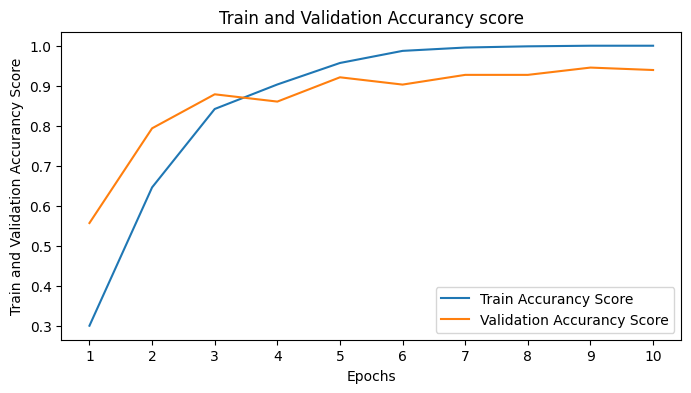

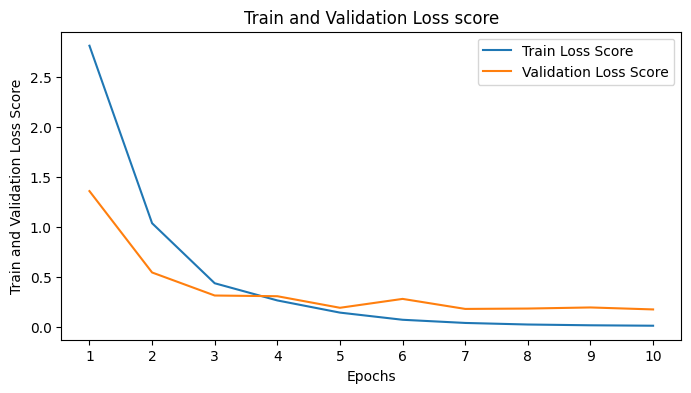

In [14]:
def plot(res):
    
    plt.figure(figsize=(8, 4))
    plt.plot(res["tr_acc_sc"], label = "Train Accurancy Score" )
    plt.plot(res["val_acc_sc"], label = "Validation Accurancy Score")
    plt.title("Train and Validation Accurancy score")
    plt.xlabel("Epochs")
    plt.xticks(np.arange(len(res["val_acc_sc"])), [i for i in range(1, len(res["val_acc_sc"])+1)])
    plt.ylabel("Train and Validation Accurancy Score")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(res["tr_epochs_loss"], label = "Train Loss Score" )
    plt.plot(res["val_epochs_loss"], label = "Validation Loss Score")
    plt.title("Train and Validation Loss score")
    plt.xlabel("Epochs")
    plt.xticks(np.arange(len(res["val_acc_sc"])), [i for i in range(1, len(res["val_acc_sc"])+1)])
    plt.ylabel("Train and Validation Loss Score")
    plt.legend()
    plt.show()
    
plot(result)

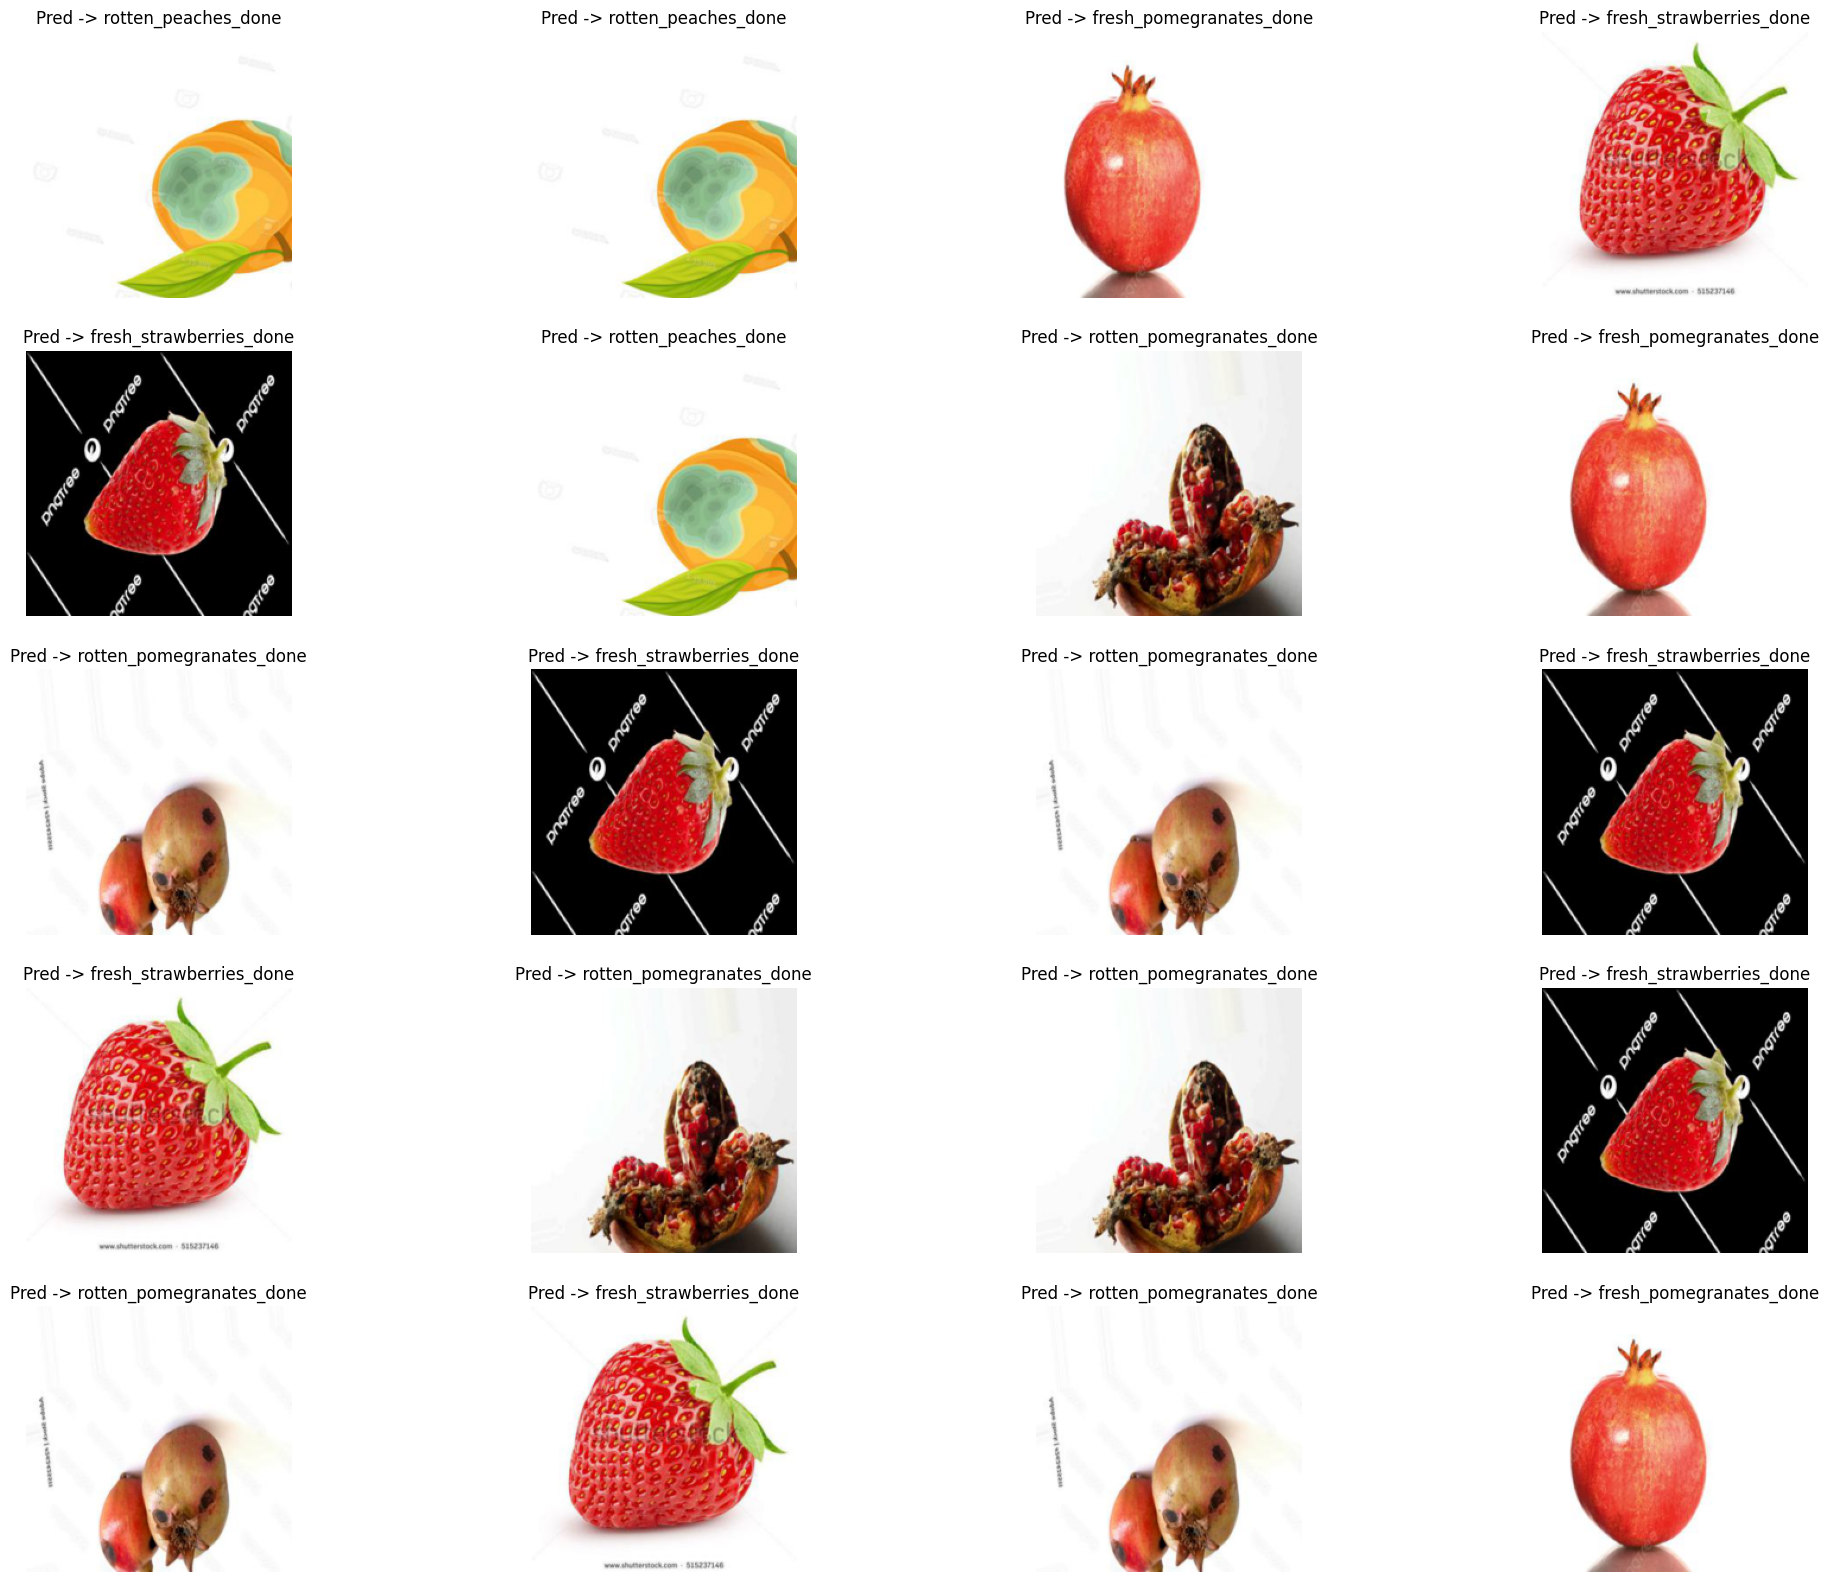

In [18]:
def inference(model, datas, device, num_images, rows, class_name):
    predictions, images =[],[]
    for idx, data in enumerate(datas):
    
        im =data[0]
        # print(im[0].shape)
        im = im.to(device)
        pred = torch.argmax(model(im[0].unsqueeze(dim=0)), dim=1)
        images.append(im)
        predictions.append(pred.item())

    index_num = [random.randint(0, len(datas)-1) for _ in range(num_images)]
    plt.figure(figsize=(25, 20))
    for idx, index in enumerate(index_num):
        im = images[index].squeeze()
        plt.subplot(rows, num_images//rows, idx+1)
        plt.imshow(tn_2_im(im[0].squeeze(dim=0)))
        
        plt.axis('off')
        if class_name is not None:
            plt.title(f"Pred -> {class_name[int(predictions[index])]}")
            plt.axis("off")
        else:
            plt.title(f"pred -> {predictions[index]}")
    plt.show()
model = torch.load("fruits_best_model/fruits_best_model.pht")
inference(model = model.to(device), datas = ts_dl, device = device, num_images = 20, rows = 5, class_name = list(classes.keys()))
    

In [19]:
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

def inference(model, device, test_dl, num_ims, row, klass_nomlari = None, rasm_hajmi = None):
    
    # Accuracy hisoblash uchun o'zgaruvchi
    aniqlilik = 0
    # Listlarni yaratib olamiz
    hamma_bashoratlar, hamma_rasmlar, hamma_javoblar = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        # if idx == 3: break
        # har bir batchda (batch sizega teng bo'lgan) rasm va javoblar bor
        rasmlar, javoblar = batch
        rasmlar, javoblar = rasmlar.to(device), javoblar.to(device)
        # argmax (eng katta qiymat turgan indeksni qaytaradi) da dim = 1 olishimning sababi logits lar bo'yicha qaytaradi
        bashoratlar = torch.argmax(model(rasmlar), dim = 1)
        aniqlilik += (bashoratlar == javoblar).sum().item()
        hamma_rasmlar.append(rasmlar)
        hamma_bashoratlar.append(bashoratlar.item())
        hamma_javoblar.append(javoblar.item())
    
    print(f"Accuracy of the model on the test data -> {(aniqlilik / len(test_dl.dataset)):.3f}")
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(hamma_rasmlar) - 1) for _ in range(num_ims)]
    
    for idx, indeks in enumerate(indekslar):
        
        # triplet - 3 ta; pair - 2ta
        rasm = hamma_rasmlar[indeks].squeeze()
        javob = hamma_javoblar[indeks]; bashorat = hamma_bashoratlar[indeks]
        
        # GradCAM -> array (CPU) lar bilan ishlaydi;
        orig_rasm = tensor_2_im(rasm) / 255
        
        cam = GradCAMPlusPlus(model = model, target_layers = [model.features[-1]], use_cuda = True)
        # print(cam(input_tensor = rasm.unsqueeze(0)).shape)
        # print(cam(input_tensor = rasm.unsqueeze(0))[0, :].shape)
        grayscale_cam = cam(input_tensor = rasm.unsqueeze(0))[0, :]
        heatmap = show_cam_on_image(img = orig_rasm, mask = grayscale_cam, image_weight = 0.1, use_rgb = True)
        
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(rasm), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (rasm_hajmi, rasm_hajmi), interpolation = cv2.INTER_LINEAR), alpha = 0.5, cmap = "jet"); plt.axis("off")
        
        rang = ("green" if {klass_nomlari[int(javob)]} == {klass_nomlari[int(bashorat)]} else "red")
        if klass_nomlari: plt.title(f"Javob -> {klass_nomlari[javob]} ; Bashorat -> {klass_nomlari[bashorat]}", color = rang)
        else: plt.title(f"Javob -> {javob} ; Bashorat -> {bashorat}")
        
model = torch.load("fruits_best_model/fruits_best_model.pht")
model.eval()
inference(model = model.to(device), device = device, test_dl = ts_dl, num_ims = 20, row = 4, klass_nomlari = list(classes.keys()), rasm_hajmi = 224)

0it [00:00, ?it/s]


RuntimeError: a Tensor with 32 elements cannot be converted to Scalar